In [7]:
from PIL import Image, ImageDraw, ImageFont
HEIGHT, WIDTH = 480, 800
MAX_WIDTH_RATIO = 0.8
import re

In [ ]:
font = ImageFont.truetype("../data/fonts/CormorantGaramond-VariableFont_wght.ttf", 24)
bold_font = ImageFont.truetype("../data/fonts/CormorantGaramond-VariableFont_wght.ttf", 24)
bold_font.set_variation_by_axes([1000])

italic_font = ImageFont.truetype("../data/fonts/CormorantGaramond-Italic-VariableFont_wght.ttf", 24)

In [22]:
def parse_quote(text: str) -> list[tuple[str, bool]]:
    """Parse quote into segments: list of (text, is_bold)"""
    segments = []
    pattern = re.compile(r"(<b>.*?</b>)")
    parts = pattern.split(text)
    for part in parts:
        if part.startswith("<b>") and part.endswith("</b>"):
            segments.append((part[3:-4], True))
        else:
            segments.append((part, False))
    return segments
    
def draw_quote(
    quote: str,
    draw: ImageDraw.ImageDraw,
    display_wh_px: tuple[int, int],
    max_width_ratio: float,
    font: ImageFont.FreeTypeFont,
    font_bold: ImageFont.FreeTypeFont,
) -> None:
    max_line_width_px = int(display_wh_px[0] * max_width_ratio)

    segments = parse_quote(quote)

    # Split segments into words, retaining bold info
    words = []
    for segment, is_bold in segments:
        for word in segment.split():
            words.append((word, is_bold))

    # Word wrapping with bold-aware measurement
    lines = []
    curr_line = []
    while words:
        word, is_bold = words.pop(0)
        test_line = curr_line + [(word, is_bold)]
        test_text = " ".join(w for w, _ in test_line)
        test_width = 0
        for w, bold in test_line:
            f = font_bold if bold else font
            bbox = draw.textbbox((0, 0), w, font=f)
            test_width += bbox[2] - bbox[0]
        test_width += (len(test_line) - 1) * draw.textlength(" ", font=font)  # add spaces

        if test_width <= max_line_width_px:
            curr_line = test_line
        else:
            lines.append(curr_line)
            curr_line = [(word, is_bold)]

    # Handle trailing line
    if curr_line:
        lines.append(curr_line)

    # Figure out the text's height [px]
    line_height = max(font.getbbox("Ay")[3] - font.getbbox("Ay")[1],
                      font_bold.getbbox("Ay")[3] - font_bold.getbbox("Ay")[1])
    total_height = len(lines) * line_height
    y_offset = (display_wh_px[1] - total_height) // 2

    # Draw each line
    for line in lines:
        # Measure total line width
        line_width = 0
        for word, bold in line:
            f = font_bold if bold else font
            bbox = draw.textbbox((0, 0), word, font=f)
            line_width += bbox[2] - bbox[0]
        line_width += (len(line) - 1) * draw.textlength(" ", font=font)

        x_offset = (display_wh_px[0] - line_width) // 2

        # Draw each word
        for i, (word, bold) in enumerate(line):
            f = font_bold if bold else font
            draw.text((x_offset, y_offset), word, font=f, fill=0)
            word_width = draw.textbbox((x_offset, y_offset), word, font=f)[2] - x_offset
            x_offset += word_width
            if i < len(line) - 1:
                space_width = draw.textlength(" ", font=font)
                x_offset += space_width

        y_offset += line_height

In [23]:
image = Image.new(mode='L', size=(WIDTH, HEIGHT), color=255)
draw = ImageDraw.Draw(image)

quote = "This is a long string that <b>should automatically waaaaaaaaaaaaaaaaaaarap</b> to the next line once it reaches a certain width limit."
draw_quote(quote, draw, (WIDTH, HEIGHT), 0.8, font, bold_font)

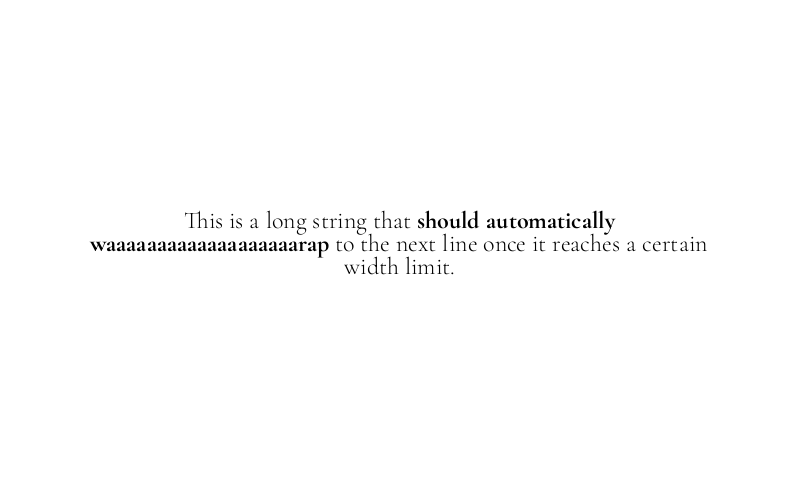

In [24]:
image